# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
########### Basic Parameters for Running: ################################
    
TFliteNamingAndVersion = "ana1000s3"   # Used for tflite Filename
Training_Percentage = 0.2              # 0.0 = Use all Images for Training
Epoch_Anz = 100

##########################################################################



import os
import tensorflow as tf
import matplotlib.pyplot as plt
import glob
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import History 
import math
from PIL import Image 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training in the first 3 digits::
* Typical filename: 
    * x.y-zzzz.jpg 
    * e.g. "4.6_Lfd-1406_zeiger3_2019-06-02T050011"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **x.y**          | readout value               | **to be learned** |
| zzzz        | additional information              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]
    * The periodic nature is reflected in a **sin/cos coding**, which allows to restore the angle/counter value with an arctan later on.

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    target_number = (float(base[0:3])) / 10
    target_sin = math.sin(target_number * math.pi * 2)
    target_cos = math.cos(target_number * math.pi * 2)

    x_data.append(test_image)
    zw = np.array([target_sin, target_cos])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)

if (Training_Percentage > 0):
    X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=Training_Percentage)
else:
    X_train = x_data
    y_train = y_data

(5761, 32, 32, 3)
(5761, 2)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (2) - sin and cos

In [3]:
inputs = tf.keras.Input(shape=(32, 32, 3))
inputs2 = tf.keras.layers.BatchNormalization()(inputs)
inputs3 = tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation="relu")(inputs2)
inputs4 = tf.keras.layers.MaxPool2D(pool_size=(4,4))(inputs3)
inputs5 = tf.keras.layers.Conv2D(16, (5, 5), padding='same', activation="relu")(inputs4)
inputs6 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs5)
inputs7 = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation="relu")(inputs6)
inputs8 = tf.keras.layers.MaxPool2D(pool_size=(2,2))(inputs7)
inputs9 = tf.keras.layers.Flatten()(inputs8)
inputs10 = tf.keras.layers.Dense(64,activation="relu")(inputs9)
inputs11 = tf.keras.layers.Dense(32,activation="relu")(inputs10)
output = tf.keras.layers.Dense(2)(inputs11)

model = tf.keras.Model(inputs=inputs, outputs=output)

model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

model.summary()

#model = Sequential()
#model.add(BatchNormalization(input_shape=(32,32,3)))
#model.add(Conv2D(32, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(4,4)))
#model.add(Conv2D(16, (5, 5), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(4,4)))
#model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
#model.add(MaxPool2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(64,activation="relu"))
#model.add(Dense(32,activation="relu"))
#model.add(Dense(2))
#model.summary()

#model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95), metrics = ["accuracy"])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 3)        12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 16)          12816     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 16)         0     

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 30
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)



Epoch 1/30


/var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/ipykernel_47812/3831122756.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
2022-07-15 21:40:14.667723: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


721/721 [==============================] - 3s 4ms/step - loss: 0.1640 - accuracy: 0.8452 - val_loss: 0.0325 - val_accuracy: 0.9627
Epoch 2/30
721/721 [==============================] - 3s 4ms/step - loss: 0.0235 - accuracy: 0.9625 - val_loss: 0.0122 - val_accuracy: 0.9731
Epoch 3/30
721/721 [==============================] - 3s 4ms/step - loss: 0.0134 - accuracy: 0.9708 - val_loss: 0.0060 - val_accuracy: 0.9748
Epoch 4/30
721/721 [==============================] - 3s 5ms/step - loss: 0.0086 - accuracy: 0.9729 - val_loss: 0.0106 - val_accuracy: 0.9627
Epoch 5/30
721/721 [==============================] - 3s 5ms/step - loss: 0.0063 - accuracy: 0.9767 - val_loss: 0.0049 - val_accuracy: 0.9809
Epoch 6/30
721/721 [==============================] - 3s 5ms/step - loss: 0.0048 - accuracy: 0.9792 - val_loss: 0.0032 - val_accuracy: 0.9879
Epoch 7/30
721/721 [==============================] - 3s 5ms/step - loss: 0.0038 - accuracy: 0.9816 - val_loss: 0.0034 - val_accuracy: 0.9792
Epoch 8/30
721/72

### Step 1: Learing result
 
* Visualization of the training and validation results

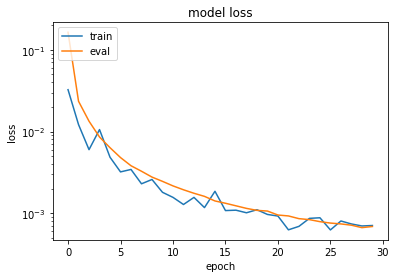

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])

if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)

plt.semilogy(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 160
Shift_Range = 3
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

if (Training_Percentage > 0):
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)
else:
    train_iterator = datagen.flow(x_data, y_data, batch_size=Batch_Size)
    history = model.fit_generator(train_iterator, epochs = Epoch_Anz)


Epoch 1/160
 21/721 [..............................] - ETA: 3s - loss: 0.3997 - accuracy: 0.7024

/var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/ipykernel_47812/1492021130.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)


721/721 [==============================] - 5s 6ms/step - loss: 0.0628 - accuracy: 0.9224 - val_loss: 0.0134 - val_accuracy: 0.9523
Epoch 2/160
721/721 [==============================] - 5s 6ms/step - loss: 0.0102 - accuracy: 0.9651 - val_loss: 0.0097 - val_accuracy: 0.9679
Epoch 3/160
721/721 [==============================] - 5s 6ms/step - loss: 0.0080 - accuracy: 0.9743 - val_loss: 0.0077 - val_accuracy: 0.9705
Epoch 4/160
721/721 [==============================] - 5s 6ms/step - loss: 0.0058 - accuracy: 0.9776 - val_loss: 0.0039 - val_accuracy: 0.9809
Epoch 5/160
721/721 [==============================] - 5s 6ms/step - loss: 0.0053 - accuracy: 0.9821 - val_loss: 0.0058 - val_accuracy: 0.9818
Epoch 6/160
721/721 [==============================] - 5s 6ms/step - loss: 0.0042 - accuracy: 0.9833 - val_loss: 0.0059 - val_accuracy: 0.9705
Epoch 7/160
721/721 [==============================] - 5s 6ms/step - loss: 0.0036 - accuracy: 0.9851 - val_loss: 0.0029 - val_accuracy: 0.9844
Epoch 8/160

### Overall Learing results (Step 1 & Step 2)

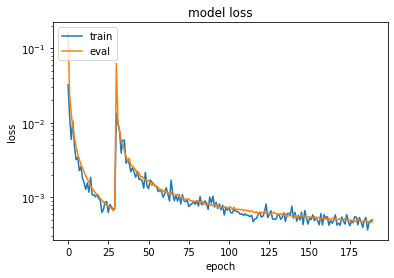

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])


if (Training_Percentage > 0):
    val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])
    plt.semilogy(val_loss_ges)


plt.semilogy(loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account (dev1 ... dev2).
* Images, that have a bigger deviation as the parameter "deviation_max_list" are printed in a list to check the picture and labeling itself

In [8]:
Input_dir='data_resize_all'
#Input_dir='test_result'
files = glob.glob(Input_dir + '/*.*')
res = []
stat_Anz = []
stat_Abweichung = []
i = 0
deviation_max_list = 0.05

for i in range(100):
    stat_Anz.append(0)
    stat_Abweichung.append(0)

for aktfile in sorted(files):
    base = os.path.basename(aktfile)
    target = (float(base[0:3])) / 10
    
    target_sin = math.sin(target * math.pi * 2)
    target_cos = math.cos(target * math.pi * 2)

    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img, verbose=0)
    
    out_sin = classes[0][0]  
    out_cos = classes[0][1]
    out_target = (np.arctan2(out_sin, out_cos)/(2*math.pi)) % 1

    dev_sin = target_sin - out_sin
    dev_cos = target_cos - out_cos
    dev_target = target - out_target
    
    if abs(dev_target + 1) < abs(dev_target):
        out_target = out_target - 1
        dev_target = target - out_target
    else:
        if abs(dev_target - 1) < abs(dev_target):
            out_target = out_target + 1
            dev_target = target - out_target
            
    target_int = int ((float(base[0:3])) * 10)
    stat_Abweichung[target_int] = stat_Abweichung[target_int] + dev_target  
    stat_Anz[target_int] = stat_Anz[target_int] + 1
               
    res.append(np.array([target, out_target, dev_target, out_sin, out_cos, i]))
    if abs(dev_target) > deviation_max_list:
        print(aktfile + " " + str(target) + " " + str(out_target) +  " " + str(dev_target))

    
for i in range(100):
    stat_Abweichung[i] = stat_Abweichung[i] / stat_Anz[i]

res = np.asarray(res)
res_step_1 = res

data_resize_all/0.0_0006_zeiger1_2020-04-29_10-56-43.jpg 0.0 -0.11319044513513443 0.11319044513513443
data_resize_all/0.0_0007_zeiger1_2020-04-29_12-15-02.jpg 0.0 -0.08980070896814585 0.08980070896814585
data_resize_all/0.0_0009_zeiger1_2020-04-29_13-35-02.jpg 0.0 -0.1479632322772586 0.1479632322772586
data_resize_all/0.1_0008_zeiger1_2020-04-29_12-16-02.jpg 0.01 -0.11725285192598112 0.12725285192598113
data_resize_all/0.1_0010_zeiger1_2020-04-29_13-36-02.jpg 0.01 -0.07155336530901668 0.08155336530901668
data_resize_all/0.2_0055_zeiger1_2020-04-29_10-58-40.jpg 0.02 -0.09672260291413981 0.11672260291413981
data_resize_all/0.2_0061_zeiger2_2020-04-29_14-39-02.jpg 0.02 -0.03682728432852944 0.056827284328529445
data_resize_all/0.3_0056_zeiger1_2020-04-29_13-37-02.jpg 0.03 -0.10451875158752166 0.13451875158752166
data_resize_all/0.3_0098_zeiger1_2020-04-29_11-00-02.jpg 0.03 -0.11250591788469144 0.14250591788469144
data_resize_all/0.3_0130_zeiger4_2020-04-29_14-32-02.jpg 0.03 -0.039179487642

## Results

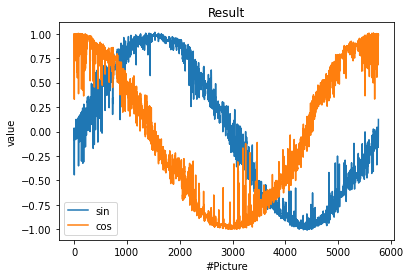

In [9]:
plt.plot(res[:,3])
plt.plot(res[:,4])
plt.title('Result')
plt.ylabel('value')
plt.xlabel('#Picture')
plt.legend(['sin', 'cos'], loc='lower left')
plt.show()

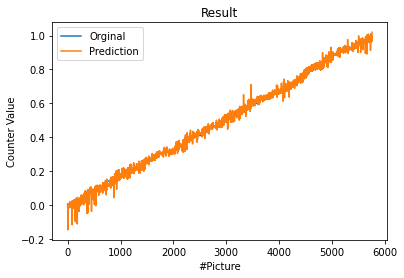

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

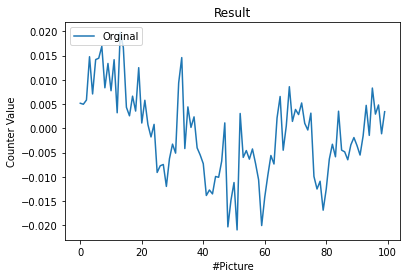

In [11]:
plt.plot(stat_Abweichung)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

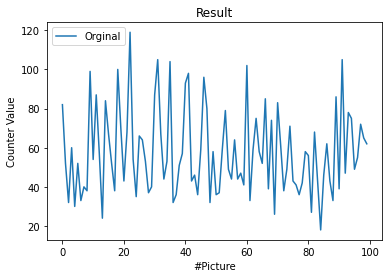

In [12]:
plt.plot(stat_Anz)
plt.title('Result')
plt.ylabel('Counter Value')
plt.xlabel('#Picture')
plt.legend(['Orginal', 'Prediction'], loc='upper left')
plt.show()

### Deviation from Expected Value

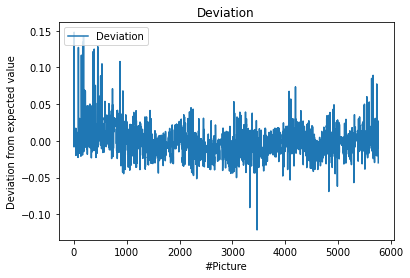

[-0.001   0.0168 -0.1212  0.148 ]


In [13]:
plt.plot(res[:,2])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['Deviation'], loc='upper left')
#plt.ylim(-0.3, 0.3)
plt.show()

statistic = np.array([np.mean(res[:,2]), np.std(res[:,2]), np.min(res[:,2]), np.max(res[:,2])])
print(statistic)

### Save the model

* Save the model to the file with the "h5" file format

In [14]:
FileName = TFliteNamingAndVersion

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open(FileName + ".tflite", "wb").write(tflite_model)

2022-07-15 21:58:27.224395: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmph7sj1ru8/assets


2022-07-15 21:58:30.930451: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-15 21:58:30.930465: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-15 21:58:30.931572: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmph7sj1ru8
2022-07-15 21:58:30.933053: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-15 21:58:30.933062: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmph7sj1ru8
2022-07-15 21:58:30.939577: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-15 21:58:31.000784: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmph7sj1ru8
2022-07-

125440

In [15]:
FileName = TFliteNamingAndVersion + "q"

import tensorflow as tf

def representative_dataset():
    for n in range(x_data[0].size):
      data = np.expand_dims(x_data[5], axis=0)
      yield [data.astype(np.float32)]
        
converter2 = tf.lite.TFLiteConverter.from_keras_model(model)
converter2.representative_dataset = representative_dataset
converter2.optimizations = [tf.lite.Optimize.DEFAULT]
converter2.representative_dataset = representative_dataset
tflite_quant_model = converter2.convert()


open(FileName + ".tflite", "wb").write(tflite_quant_model)

INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmp4276b7mo/assets


INFO:tensorflow:Assets written to: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmp4276b7mo/assets
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:746: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-07-15 21:58:35.045255: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-07-15 21:58:35.045269: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-07-15 21:58:35.045353: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/07/sj9pw71n205_354358yc8scm0000gn/T/tmp4276b7mo
2022-07-15 21:58:35.046708: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-07-15 21:58:35.046714: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedMode

38152